# Cartpole Bayesian Sindy with Intuitive Basis Functions

The full cartpole equations are:

$$\ddot{x}=\frac{f-ml\ddot{\theta}\cos{\theta} +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x}}{m_c + m}$$

$$\ddot{\theta}=\frac{Mg\sin{\theta} -\cos{\theta}(f +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x})-\frac{M\mu_p\dot{\theta}}{ml}}{(1+k)Ml-ml\cos^2{\theta}}$$

In [ ]:
---
execute:
    echo: true
code-fold: true
output: html
toc: true
fig-align: center
fontsize: 16px
format:
    html:
        embed-resources: true
---

In [2]:
using Turing, DifferentialEquations, StatsPlots, LinearAlgebra, Random

## Sim Data

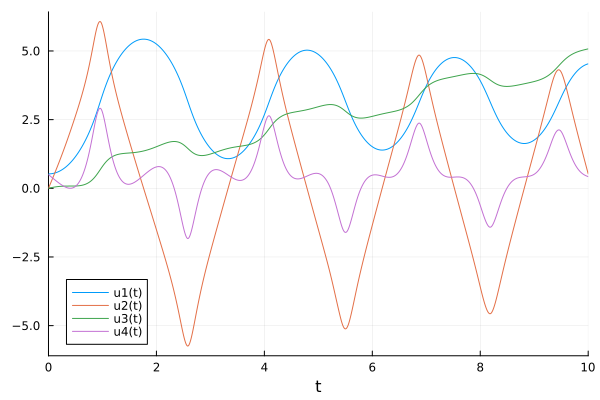

In [3]:
function cartpole!(du, u, p, t)
    # u = [theta, theta_d, x, x_d]

    # external force
    # force = -0.2+0.5*sin(6*t)
    force = 0

    # Parameters
    m1, m2, gravity, length, mu_c, mu_p, k_inertia = p

    # theta_d
    du[1] = u[2]

    # theta_dd
    du[2] = ((m1+m2)*gravity*sin(u[1])-cos(u[1])*(force+m2*length*(u[2]^2)*sin(u[1])-mu_c*u[4])-((m1+m2)*mu_p*u[2])/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(cos(u[1]))^2)

    # x_d
    du[3] = u[4]

    # x_dd
    du[4] = (force-m2*length*(du[2]*cos(u[1])-(u[2]^2)*sin(u[1]))-mu_c*u[4]) / (m1+m2)
end

# Parameters 
# p = (1.0, 0.1, 9.8, 0.5, 0.05, 0.01, 1/3)
p = (1.5, 1.0, 9.8, 1.0, 0.05, 0.1, 1/3)

# Initial conditions
u0 = [0.524, 0.0, 0.0, 0.5]  # 30 degrees, 2 m/s to the right

tspan = (0.0,10.0)
probCart = ODEProblem(cartpole!,u0,tspan,p)

# Solve
sol = solve(probCart, Tsit5())

X = Array(sol)
t = sol.t
DX = Array(sol(sol.t,Val{1}))[[2], :]

plot(sol)


$$\ddot{x}=\frac{f-ml\ddot{\theta}\cos{\theta} +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x}}{m_c + m}$$

$$\ddot{\theta}=\frac{Mg\sin{\theta} -\cos{\theta}(f +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x})-\frac{M\mu_p\dot{\theta}}{ml}}{(1+k)Ml-ml\cos^2{\theta}}$$

### Generate dummy data for estimation

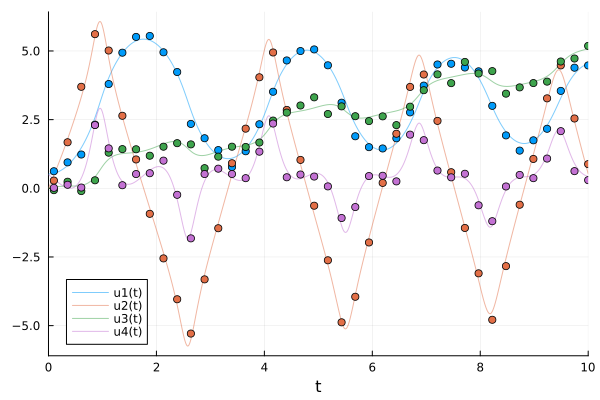

In [4]:
t = collect(range(0.1, stop=10, length=40))

odedata = Array(solve(probCart, saveat=t))
odedata = odedata + 0.2 * randn(size(odedata))
plot(sol; alpha=0.5)
scatter!(t, odedata'; color=[1 2 3 4], label="")


## Parameter Estimation

The purpose of this notebook is to encode *some* information in the basis functions; namely:

* Friction: it is expected both \ddot{\theta} and \ddot{x} will have a small negative coefficient for \dot{\theta} and \dot{x}, respectively.
* Angle importance: *All* other basis functions will involve \sin{\theta} or \cos{\theta}. This is based on intuition--observing the system, the angle of the pendulum is the driving force in how the system responds


In [5]:
# #| output: false
# function cartpoleSindy!(du, u, p, t)
#      # u = [theta, theta_d, x, x_d]
 
#      θ, θ̇, x, ẋ = u
 
#      # Set epsilon for stability
#      eps = 1e-3

#      # theta_d and x_d
#      du[1] = θ̇ #- eps*θ^3
#      du[3] = ẋ - eps*x^3
 
#      # theta_dd
#      θ̈ = (p[1]*sin(θ) +
#           p[2]*cos(θ) + 
#           p[3]*θ̇ *sin(θ)+ 
#           p[4]*ẋ *sin(θ)+ 
#           p[5]*cos(θ) *sin(θ)+ 
#           p[6]*ẋ *cos(θ)+ 
#           p[7]*cos(θ) *θ̇ + 
#           p[8]*cos(θ)^2+ 
#           p[9]*sin(θ)^2+ 
#           p[23]*θ̇+
#           p[10] -
#           eps*θ̇ ^3  # for stability
#           )
#      du[2] = θ̈ 
     
#      # x_dd
#      du[4] = (p[11]*sin(θ) +
#               p[12]*cos(θ)+ 
#               p[13]*θ̇ *sin(θ)+ 
#               p[14]*ẋ *sin(θ)+ 
#               p[15]*θ̈ *sin(θ)+ 
#               p[16]*ẋ *cos(θ)+ 
#               p[17]*cos(θ) *θ̇+ 
#               p[18]*cos(θ) *sin(θ)+ 
#               p[19]*cos(θ) *θ̈ + 
#               p[20]*sin(θ)^2+ 
#               p[21]*cos(θ)^2+ 
#               p[24]*ẋ+
#               p[22] -
#               eps*ẋ^3  # for stability
#               )
#  end
# cartpoleProb = ODEProblem(cartpoleSindy!, u0, tspan, [0.0 for _ in 1:24])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 4-element Vector{Float64}:
 0.524
 0.0
 0.0
 0.5

In [34]:
#| output: false
function cartpoleSindy!(du, u, p, t)
     # u = [theta, theta_d, x, x_d]
 
     θ, θ̇, x, ẋ = u
 
     # Set epsilon for stability
     eps = 1e-3

     # theta_d and x_d
     du[1] = θ̇ #- eps*θ^3
     du[3] = ẋ - eps*x^3
 
     # theta_dd
     θ̈ = (p[1]*sin(θ) +
          p[2]*cos(θ) + 
          p[3]*θ̇ *sin(θ)+ 
          p[4]*ẋ *sin(θ)+ 
          p[5]*ẋ *cos(θ)+ 
          p[6]*cos(θ) *θ̇ + 
          p[7]*cos(θ) *sin(θ)+ 
          p[8]*cos(θ)^2+ 
          p[9]*sin(θ)^2+ 
          p[10]*θ̇ *cos(θ) *sin(θ)+ 
          p[11]*θ̇ *cos(θ)^2+ 
          p[12]*θ̇ *sin(θ)^2+ 
          p[13]*ẋ*cos(θ)*sin(θ)+ 
          p[14]*ẋ*cos(θ)^2+ 
          p[15]*ẋ*sin(θ)^2+ 
          p[38]*θ̇ +
          p[16] -
          eps*θ̇ ^3  # for stability
          )
     du[2] = θ̈ 
     
     # x_dd
     du[4] = (p[17]*sin(θ) +
              p[18]*cos(θ)+ 
              p[19]*θ̇ *sin(θ)+ 
              p[20]*ẋ *sin(θ)+ 
              p[21]*θ̈ *sin(θ)+ 
              p[22]*ẋ *cos(θ)+ 
              p[23]*cos(θ) *θ̇+ 
              p[24]*cos(θ) *θ̈ + 
              p[25]*cos(θ) *sin(θ)+ 
              p[26]*sin(θ)^2+ 
              p[27]*cos(θ)^2+ 
              p[28]*ẋ*cos(θ) *sin(θ)+ 
              p[29]*ẋ*sin(θ)^2+ 
              p[30]*ẋ*cos(θ)^2+ 
              p[31]*θ̇ *cos(θ) *sin(θ)+ 
              p[32]*θ̇ *sin(θ)^2+ 
              p[33]*θ̇ *cos(θ)^2+ 
              p[34]*θ̈ *cos(θ) *sin(θ)+ 
              p[35]*θ̈ *sin(θ)^2+ 
              p[36]*θ̈ *cos(θ)^2+ 
              p[39]*ẋ+
              p[37] -
              eps*ẋ^3  # for stability
              )
 end
cartpoleProb = ODEProblem(cartpoleSindy!, u0, tspan, [0.0 for _ in 1:39])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 4-element Vector{Float64}:
 0.524
 0.0
 0.0
 0.5

In [35]:
#| output: false
@model function fitCartpoleLaplace(data, ::Type{T} = Float64) where {T <: Real}

    # Prior distributions - small except for base sin and cosine terms
    se = [
        1.0,
        1.0,
        0.1,
        0.1, 
        0.1, 
        0.1, 
        0.1, 
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        1.0,
        1.0,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
    ]
    base_priors = [Laplace(0.0, se[i]) for i in 1:37]
    neg_priors = [Truncated(Laplace(0.0, 0.1), -Inf, 0) for _ in 1:2]
    priors = vcat(base_priors, neg_priors)
    # priors = [Laplace(0.0, 0.1) for i in 1:36]
    theta = Vector{T}(undef, length(priors))
    syms = [Turing.@varname(theta[i]) for i in 1:length(priors)]
    for i in 1:length(priors)
        theta[i] ~ NamedDist(priors[i], syms[i])
    end

    σ ~ InverseGamma(2, 0.5)

    p = convert.(T, theta)
    u0 = convert.(T, cartpoleProb.u0)

    # Simulate model
    predicted = solve(cartpoleProb, Tsit5(); p=p, saveat=t)
    predicted_dense = solve(cartpoleProb, Tsit5(); p=p)
    failure = size(predicted, 2) < length(t)

    if failure
        Turing.@addlogprob! -Inf
        return
    end

    # Observations
    for i in 1:length(t)
        data[:, i] ~ MvNormal(predicted[:, i], σ^2 * I)
    end

    # return nothing
    return (; theta, predicted_dense)
end


fitCartpoleLaplace (generic function with 3 methods)

In [36]:
#| output: false
using Suppressor

modelHorse = fitCartpoleLaplace(odedata)
# chain5 = 6
# output = @capture_err chain5 = sample(modelHorse, NUTS(0.65; init_ϵ=0.01), MCMCSerial(), 500, 2; progress=true)
# chain5

chain5 = sample(modelHorse, NUTS(0.65; init_ϵ=0.01), MCMCSerial(), 500, 2; progress=true)

Sampling (Chain 1 of 2)   0%|█                          |  ETA: N/A
Sampling (Chain 1 of 2)   0%|█                          |  ETA: 1:07:58
Sampling (Chain 1 of 2)   1%|█                          |  ETA: 0:34:12
Sampling (Chain 1 of 2)   1%|█                          |  ETA: 0:23:17
Sampling (Chain 1 of 2)   2%|█                          |  ETA: 0:19:36
Sampling (Chain 1 of 2)   2%|█                          |  ETA: 0:17:41
Sampling (Chain 1 of 2)   2%|█                          |  ETA: 0:15:00
Sampling (Chain 1 of 2)   3%|█                          |  ETA: 0:13:23
Sampling (Chain 1 of 2)   3%|█                          |  ETA: 0:11:58
Sampling (Chain 1 of 2)   4%|█                          |  ETA: 0:15:43
Sampling (Chain 1 of 2)   4%|██                         |  ETA: 0:18:33
Sampling (Chain 1 of 2)   4%|██                         |  ETA: 0:20:52
Sampling (Chain 1 of 2)   5%|██                         |  ETA: 0:22:48
Sampling (Chain 1 of 2)   5%|██                         |  ETA: 0:25

Sampling (Chain 1 of 2)  40%|███████████                |  ETA: 0:34:34
Sampling (Chain 1 of 2)  40%|███████████                |  ETA: 0:34:22
Sampling (Chain 1 of 2)  41%|████████████               |  ETA: 0:34:10
Sampling (Chain 1 of 2)  41%|████████████               |  ETA: 0:33:57
Sampling (Chain 1 of 2)  42%|████████████               |  ETA: 0:33:46
Sampling (Chain 1 of 2)  42%|████████████               |  ETA: 0:33:33
Sampling (Chain 1 of 2)  42%|████████████               |  ETA: 0:33:20
Sampling (Chain 1 of 2)  43%|████████████               |  ETA: 0:33:08
Sampling (Chain 1 of 2)  43%|████████████               |  ETA: 0:32:55
Sampling (Chain 1 of 2)  44%|████████████               |  ETA: 0:32:43
Sampling (Chain 1 of 2)  44%|████████████               |  ETA: 0:32:30
Sampling (Chain 1 of 2)  44%|████████████               |  ETA: 0:32:20
Sampling (Chain 1 of 2)  45%|█████████████              |  ETA: 0:32:06
Sampling (Chain 1 of 2)  45%|█████████████              |  ETA: 

Sampling (Chain 1 of 2)  80%|██████████████████████     |  ETA: 0:12:19
Sampling (Chain 1 of 2)  80%|██████████████████████     |  ETA: 0:12:04
Sampling (Chain 1 of 2)  81%|██████████████████████     |  ETA: 0:11:49
Sampling (Chain 1 of 2)  81%|██████████████████████     |  ETA: 0:11:35
Sampling (Chain 1 of 2)  82%|███████████████████████    |  ETA: 0:11:20
Sampling (Chain 1 of 2)  82%|███████████████████████    |  ETA: 0:11:05
Sampling (Chain 1 of 2)  82%|███████████████████████    |  ETA: 0:10:50
Sampling (Chain 1 of 2)  83%|███████████████████████    |  ETA: 0:10:36
Sampling (Chain 1 of 2)  83%|███████████████████████    |  ETA: 0:10:21
Sampling (Chain 1 of 2)  84%|███████████████████████    |  ETA: 0:10:06
Sampling (Chain 1 of 2)  84%|███████████████████████    |  ETA: 0:09:51
Sampling (Chain 1 of 2)  84%|███████████████████████    |  ETA: 0:09:36
Sampling (Chain 1 of 2)  85%|███████████████████████    |  ETA: 0:09:22
Sampling (Chain 1 of 2)  85%|████████████████████████   |  ETA: 

Sampling (Chain 2 of 2)  19%|██████                     |  ETA: 0:44:19
Sampling (Chain 2 of 2)  20%|██████                     |  ETA: 0:44:16
Sampling (Chain 2 of 2)  20%|██████                     |  ETA: 0:44:12
Sampling (Chain 2 of 2)  20%|██████                     |  ETA: 0:44:05
Sampling (Chain 2 of 2)  21%|██████                     |  ETA: 0:43:56
Sampling (Chain 2 of 2)  21%|██████                     |  ETA: 0:43:47
Sampling (Chain 2 of 2)  22%|██████                     |  ETA: 0:43:39
Sampling (Chain 2 of 2)  22%|██████                     |  ETA: 0:43:28
Sampling (Chain 2 of 2)  22%|███████                    |  ETA: 0:43:19
Sampling (Chain 2 of 2)  23%|███████                    |  ETA: 0:43:09
Sampling (Chain 2 of 2)  23%|███████                    |  ETA: 0:42:59
Sampling (Chain 2 of 2)  24%|███████                    |  ETA: 0:42:50
Sampling (Chain 2 of 2)  24%|███████                    |  ETA: 0:42:42
Sampling (Chain 2 of 2)  24%|███████                    |  ETA: 

Sampling (Chain 2 of 2)  59%|████████████████           |  ETA: 0:24:23
Sampling (Chain 2 of 2)  59%|████████████████           |  ETA: 0:24:10
Sampling (Chain 2 of 2)  60%|█████████████████          |  ETA: 0:23:56
Sampling (Chain 2 of 2)  60%|█████████████████          |  ETA: 0:23:43
Sampling (Chain 2 of 2)  60%|█████████████████          |  ETA: 0:23:29
Sampling (Chain 2 of 2)  61%|█████████████████          |  ETA: 0:23:15
Sampling (Chain 2 of 2)  61%|█████████████████          |  ETA: 0:23:02
Sampling (Chain 2 of 2)  62%|█████████████████          |  ETA: 0:22:48
Sampling (Chain 2 of 2)  62%|█████████████████          |  ETA: 0:22:34
Sampling (Chain 2 of 2)  62%|█████████████████          |  ETA: 0:22:21
Sampling (Chain 2 of 2)  63%|█████████████████          |  ETA: 0:22:07
Sampling (Chain 2 of 2)  63%|██████████████████         |  ETA: 0:21:54
Sampling (Chain 2 of 2)  64%|██████████████████         |  ETA: 0:21:40
Sampling (Chain 2 of 2)  64%|██████████████████         |  ETA: 

Sampling (Chain 2 of 2)  98%|███████████████████████████|  ETA: 0:01:00
Sampling (Chain 2 of 2)  99%|███████████████████████████|  ETA: 0:00:45
Sampling (Chain 2 of 2)  99%|███████████████████████████|  ETA: 0:00:30
Sampling (Chain 2 of 2) 100%|███████████████████████████|  ETA: 0:00:15
Sampling (Chain 2 of 2) 100%|███████████████████████████| Time: 1:02:35
Sampling (Chain 2 of 2) 100%|███████████████████████████| Time: 1:02:35


Chains MCMC chain (500×52×2 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 2
Samples per chain = 500
Wall duration     = 7447.0 seconds
Compute duration  = 7446.47 seconds
parameters        = theta[1], theta[2], theta[3], theta[4], theta[5], theta[6], theta[7], theta[8], theta[9], theta[10], theta[11], theta[12], theta[13], theta[14], theta[15], theta[16], theta[17], theta[18], theta[19], theta[20], theta[21], theta[22], theta[23], theta[24], theta[25], theta[26], theta[27], theta[28], theta[29], theta[30], theta[31], theta[32], theta[33], theta[34], theta[35], theta[36], theta[37], theta[38], theta[39], σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   F

In [37]:
#| output: false
# Save/read samples
path = "../../learnedModels/bayesianSindy/chain-cartpole-stable4.jls"
if @isdefined chain5
    write(path, chain5)
else
    chain5 = read(path, Chains)
end

In [38]:
#| output: false
using DataFramesMeta

finnish_chain = generated_quantities(modelHorse, MCMCChains.get_sections(chain5, :parameters))
finnish_df = reduce(vcat, DataFrame(finnish_chain[:, i]) for i in 1:size(finnish_chain, 2));


In [39]:
# #| output: false
# #| echo: false
# using DataFrames

# # Extract coefficient samples

# # Clean data from generated quantites
# samples = size(finnish_chain, 1)
# var_str = [
#     "\$sin(θ) \\rightarrow \\ddot{θ}\$",
#     "\$cos(θ) \\rightarrow \\ddot{θ}\$",
#     # "\$\\dot{x} \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{θ}\$",
#     # "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{θ}\$",
#     "\$cos(θ) * sin(θ) \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{x} * cos(θ) \\rightarrow \\ddot{θ}\$",
#     "\$cos(θ) * \\dot{θ} \\rightarrow \\ddot{θ}\$",
#     "\$cos(θ)^2 \\rightarrow \\ddot{θ}\$",
#     "\$sin(θ)^2 \\rightarrow \\ddot{θ}\$",
#     "\$const \\rightarrow \\ddot{θ}\$",
#     # "\$\\dot{θ}^2 \\rightarrow \\ddot{θ}\$",
#     # "\$\\dot{x}^2 \\rightarrow \\ddot{θ}\$",
#     "\$sin(θ) \\rightarrow \\ddot{x}\$",
#     "\$cos(θ) \\rightarrow \\ddot{x}\$",
#     # "\$\\dot{θ} \\rightarrow \\ddot{x}\$",
#     # "\$\\ddot{θ} \\rightarrow \\ddot{x}\$",
#     "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
#     "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{x}\$",
#     # "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{x}\$",
#     "\$\\ddot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
#     # "\$\\dot{x} * \\ddot{θ} \\rightarrow \\ddot{x}\$",
#     # "\$\\ddot{θ} * \\dot{θ} \\rightarrow \\ddot{x}\$",
#     "\$\\dot{x} * cos(θ) \\rightarrow \\ddot{x}\$", #placeholder
#     "\$cos(θ) * \\dot{θ} \\rightarrow \\ddot{x}\$",
#     "\$cos(θ) * sin(θ) \\rightarrow \\ddot{x}\$",
#     "\$cos(θ) * \\ddot{θ} \\rightarrow \\ddot{x}\$",
#     "\$sin(θ)^2 \\rightarrow \\ddot{x}\$",
#     "\$cos(θ)^2 \\rightarrow \\ddot{x}\$",
#     # "\$\\dot{θ}^2 \\rightarrow \\ddot{x}\$",
#     # "\$\\ddot{θ}^2 \\rightarrow \\ddot{x}\$",
#     # "\$\\dot{x}^2 \\rightarrow \\ddot{x}\$",
#     "\$const \\rightarrow \\ddot{x}\$",
#     "\$\\dot{θ} \\rightarrow \\ddot{θ}\$",
#     "\$\\dot{x} \\rightarrow \\ddot{x}\$",
# ]
# beta1 = DataFrame([finnish_chain[i, 1][:theta] for i in 1:samples], :auto)
# # beta1[!,:var] = var_str
# beta1[!,:chain] = [1 for _ in 1:size(beta1)[1]]
# beta1 = DataFrames.stack(beta1, 1:samples)
# beta2 = DataFrame([finnish_chain[i, 2][:theta] for i in 1:samples], :auto)
# # beta2[!,:var] = var_str
# beta2[!,:chain] = [2 for _ in 1:size(beta2)[1]]
# beta2 = DataFrames.stack(beta2, 1:samples)
# beta = vcat(beta1, beta2)
# beta

39000×3 DataFrame
   Row │ chain  variable  value       
       │ Int64  String    Float64     
───────┼──────────────────────────────
     1 │     1  x1         6.86883
     2 │     1  x1         1.76167
     3 │     1  x1        -0.209055
     4 │     1  x1         0.984134
     5 │     1  x1         0.853416
     6 │     1  x1        -0.27426
     7 │     1  x1        -0.215861
     8 │     1  x1        -0.0904015
   ⋮   │   ⋮       ⋮           ⋮
 38994 │     2  x500       0.249613
 38995 │     2  x500      -0.0289339
 38996 │     2  x500       0.185452
 38997 │     2  x500       0.0387996
 38998 │     2  x500       0.00616054
 38999 │     2  x500      -0.243238
 39000 │     2  x500      -0.330119
                    38985 rows omitted

In [48]:
#| output: false
using DataFrames

# Extract coefficient samples

# Clean data from generated quantites
samples = size(finnish_chain, 1)
var_str = [
    "\$sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$cos(θ) \\rightarrow \\ddot{θ}\$",
    # "\$\\dot{x} \\rightarrow \\ddot{θ}\$",
    "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{θ}\$",
    # "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * cos(θ) \\rightarrow \\ddot{θ}\$",
    "\$cos(θ) * \\dot{θ} \\rightarrow \\ddot{θ}\$",
    "\$cos(θ) * sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$cos(θ)^2 \\rightarrow \\ddot{θ}\$",
    "\$sin(θ)^2 \\rightarrow \\ddot{θ}\$",
    "\$\\dot{\theta} * cos(θ) * sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{\theta} * sin(θ)^2 \\rightarrow \\ddot{θ}\$",
    "\$\\dot{\theta} * cos(θ)^2 \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * cos(θ) * sin(θ) \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * sin(θ)^2 \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} * cos(θ)^2 \\rightarrow \\ddot{θ}\$",
    "\$const \\rightarrow \\ddot{θ}\$",
    # "\$\\dot{θ}^2 \\rightarrow \\ddot{θ}\$",
    # "\$\\dot{x}^2 \\rightarrow \\ddot{θ}\$",
    "\$sin(θ) \\rightarrow \\ddot{x}\$",
    "\$cos(θ) \\rightarrow \\ddot{x}\$",
    # "\$\\dot{θ} \\rightarrow \\ddot{x}\$",
    # "\$\\ddot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\dot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * sin(θ) \\rightarrow \\ddot{x}\$",
    # "\$\\dot{x} * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\ddot{θ} * sin(θ) \\rightarrow \\ddot{x}\$",
    # "\$\\dot{x} * \\ddot{θ} \\rightarrow \\ddot{x}\$",
    # "\$\\ddot{θ} * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * cos(θ) \\rightarrow \\ddot{x}\$", #placeholder
    "\$cos(θ) * \\dot{θ} \\rightarrow \\ddot{x}\$",
    "\$cos(θ) * \\ddot{θ} \\rightarrow \\ddot{x}\$",
    "\$cos(θ) * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$sin(θ)^2 \\rightarrow \\ddot{x}\$",
    "\$cos(θ)^2 \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * cos(θ) * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * sin(θ)^2 \\rightarrow \\ddot{x}\$",
    "\$\\dot{x} * cos(θ)^2 \\rightarrow \\ddot{x}\$",
    "\$\\dot{\theta} * cos(θ) * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\dot{\theta} * sin(θ)^2 \\rightarrow \\ddot{x}\$",
    "\$\\dot{\theta} * cos(θ)^2 \\rightarrow \\ddot{x}\$",
    "\$\\ddot{\theta} * cos(θ) * sin(θ) \\rightarrow \\ddot{x}\$",
    "\$\\ddot{\theta} * sin(θ)^2 \\rightarrow \\ddot{x}\$",
    "\$\\ddot{\theta} * cos(θ)^2 \\rightarrow \\ddot{x}\$",
    # "\$\\dot{θ}^2 \\rightarrow \\ddot{x}\$",
    # "\$\\ddot{θ}^2 \\rightarrow \\ddot{x}\$",
    # "\$\\dot{x}^2 \\rightarrow \\ddot{x}\$",
    "\$const \\rightarrow \\ddot{x}\$",
    "\$\\dot{θ} \\rightarrow \\ddot{θ}\$",
    "\$\\dot{x} \\rightarrow \\ddot{x}\$",
]
beta1 = DataFrame([finnish_chain[i, 1][:theta] for i in 1:samples], :auto)
beta1[!,:var] = var_str
beta1[!,:chain] = [1 for _ in 1:size(beta1)[1]]
beta1 = DataFrames.stack(beta1, 1:samples)
beta2 = DataFrame([finnish_chain[i, 2][:theta] for i in 1:samples], :auto)
beta2[!,:var] = var_str
beta2[!,:chain] = [2 for _ in 1:size(beta2)[1]]
beta2 = DataFrames.stack(beta2, 1:samples)
beta = vcat(beta1, beta2)
beta

39000×4 DataFrame
   Row │ var                                chain  variable  value       
       │ String                             Int64  String    Float64     
───────┼─────────────────────────────────────────────────────────────────
     1 │ $sin(θ) \\rightarrow \\ddot{θ}$        1  x1         6.86883
     2 │ $cos(θ) \\rightarrow \\ddot{θ}$        1  x1         1.76167
     3 │ $\\dot{θ} * sin(θ) \\rightarrow …      1  x1        -0.209055
     4 │ $\\dot{x} * sin(θ) \\rightarrow …      1  x1         0.984134
     5 │ $\\dot{x} * cos(θ) \\rightarrow …      1  x1         0.853416
     6 │ $cos(θ) * \\dot{θ} \\rightarrow …      1  x1        -0.27426
     7 │ $cos(θ) * sin(θ) \\rightarrow \\…      1  x1        -0.215861
     8 │ $cos(θ)^2 \\rightarrow \\ddot{θ}$      1  x1        -0.0904015
   ⋮   │                 ⋮                    ⋮       ⋮           ⋮
 38994 │ $\\dot{\theta} * cos(θ)^2 \\righ…      2  x500       0.249613
 38995 │ $\\ddot{\theta} * cos(θ) * sin(θ…      2  x500      -0.0289339
 38996 │ $\\ddot{\theta} * sin(θ)^2 \\rig…      2  x500       0.185452
 38997 │ $\\ddot{\theta} * cos(θ)^2 \\rig…      2  x500       0.0387996
 38998 │ $const \\rightarrow \\ddot{x}$         2  x500       0.00616054
 38999 │ $\\dot{θ} \\rightarrow \\ddot{θ}$      2  x500      -0.243238
 39000 │ $\\dot{x} \\rightarrow \\ddot{x}$      2  x500      -0.330119
                                                       38985 rows omitted

In [49]:
#| output: false
gd = groupby(beta, [:var, :chain])
show(combine(gd, :value => mean), allrows=true)

78×3 DataFrame
 Row │ var                                chain  value_mean   
     │ String                             Int64  Float64      
─────┼────────────────────────────────────────────────────────
   1 │ $sin(θ) \\rightarrow \\ddot{θ}$        1   7.27465
   2 │ $cos(θ) \\rightarrow \\ddot{θ}$        1   1.45857
   3 │ $\\dot{θ} * sin(θ) \\rightarrow …      1  -0.203364
   4 │ $\\dot{x} * sin(θ) \\rightarrow …      1   0.98543
   5 │ $\\dot{x} * cos(θ) \\rightarrow …      1   0.857474
   6 │ $cos(θ) * \\dot{θ} \\rightarrow …      1  -0.254899
   7 │ $cos(θ) * sin(θ) \\rightarrow \\…      1  -0.264142
   8 │ $cos(θ)^2 \\rightarrow \\ddot{θ}$      1  -0.0225981
   9 │ $sin(θ)^2 \\rightarrow \\ddot{θ}$      1   0.252136
  10 │ $\\dot{\theta} * cos(θ) * sin(θ)…      1   0.0156608
  11 │ $\\dot{\theta} * sin(θ)^2 \\righ…      1   0.196089
  12 │ $\\dot{\theta} * cos(θ)^2 \\righ…      1  -0.0288724
  13 │ $\\dot{x} * cos(θ) * sin(θ) \\ri…      1  -0.0815266
  14 │ $\\dot{x} * sin(θ)^2 

Estimated solved DE from additive equations:

#### $\ddot{\theta}$ Estimated DEs:

##### Chain 1

$$
\ddot{\theta} = 7.27\sin{\theta}+1.46\cos{\theta} -0.2\dot{\theta}\sin{\theta} + 0.99\dot{x}\sin{\theta} -0.25\dot{\theta}\cos{\theta} -0.26\cos{\theta}\sin{\theta} + 0.25\sin{\theta}^2 + 0.2\dot{\theta} *\sin{\theta}^2-0.2\dot{\theta}
$$

Removing small-ish terms:

$$
\ddot{\theta} = 7.27\sin{\theta}+1.46\cos{\theta} + 0.99\dot{x}\sin{\theta}
$$

With the parameters used, the actual DEs are roughly:

$$
\ddot{\theta}=\frac{24.5\sin{\theta} -1.0\cos{\theta}\dot{\theta}^2\sin{\theta}+0.05\dot{x}\cos{\theta}-0.25\dot{\theta}}{3.33-1.0\cos^2{\theta}}\approx7.37\sin{\theta}-0.3cos{\theta}\dot{\theta}^2\sin{\theta}
$$



##### Chain 2

$$
\ddot{\theta} = 7.0\sin{\theta}+3.76\cos{\theta} + 0.56\dot{x}\sin{\theta}+ 0.28\dot{x}\sin{\theta} -1.09\cos{\theta}^2
$$

#### $\ddot{x}$ Estimated DEs:

##### Chain 1

$$
\ddot{x} = 1.75\sin{\theta}+0.79\cos{\theta} - 0.64\dot{x} + 0.3\ddot{\theta}\sin{\theta} -0.23\sin{\theta}^2
$$

##### Chain 2

$$
\ddot{x} = 1.61\sin{\theta}+0.42\cos{\theta} - 0.23\dot{x}\cos{\theta} -0.3\dot{x}^2
$$

With the parameters used, the actual DEs are roughly:




$$
\ddot{\theta}=\frac{24.5\sin{\theta} -1.0\cos{\theta}\dot{\theta}^2\sin{\theta}+0.05\dot{x}\cos{\theta}-0.25\dot{\theta}}{3.33-1.0\cos^2{\theta}}\approx7.37\sin{\theta}-0.3cos{\theta}\dot{\theta}^2\sin{\theta}
$$

$$\ddot{x}=\frac{-1.0\ddot{\theta}\cos{\theta} +1.0\dot{\theta}^2\sin{\theta}-0.05\dot{x}}{2.5}\approx-0.4\ddot{\theta}\cos{\theta} +0.4\dot{\theta}^2\sin{\theta}$$


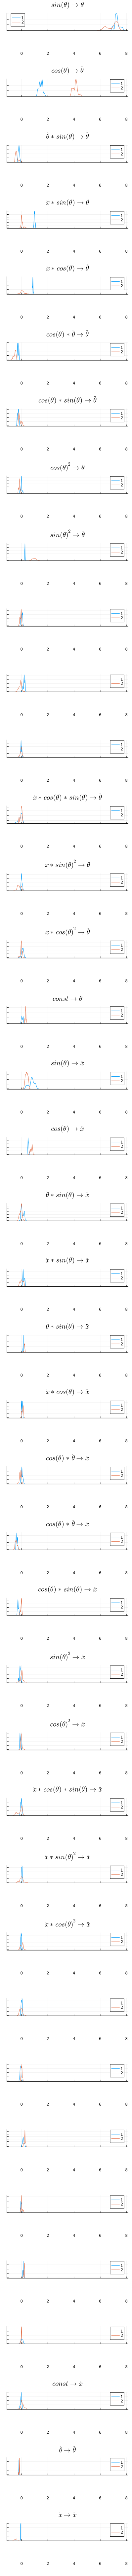

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [50]:
#| output: false
#| echo: false
gdf = groupby(beta, :var)
plot_list = []
for ((k,), v) in pairs(gdf)
    push!(plot_list, @df v density(:value, group=(:chain), title=k))
end

plot(plot_list..., layout=(length(plot_list), 1), size=(400, 200 * length(plot_list)), link = :x)
    


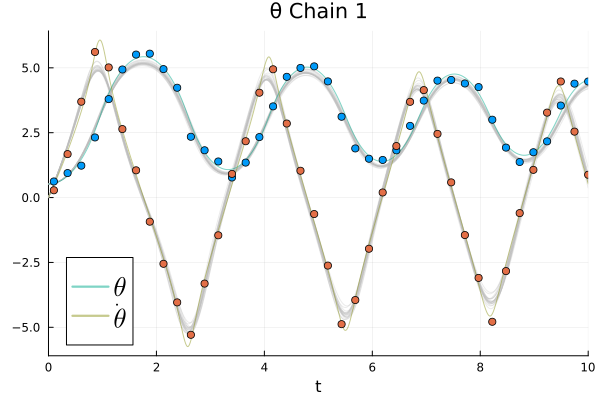

In [42]:
#| output: false
#| echo: false
plot(; title="θ Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 1:25:500
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=1, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


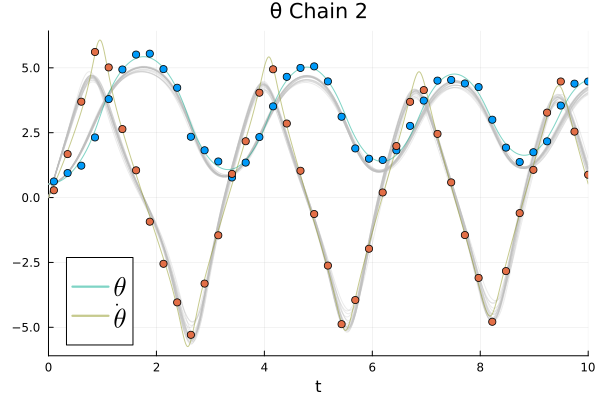

In [43]:
#| output: false
#| echo: false
plot(; title="θ Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
for i in 501:25:1000
    plot!(all_sol[i], idxs=[1, 2]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[1, 2]; alpha=0.5, linewidth=1, legend=true, label=["\$\\theta\$" "\$\\dot{\\theta}\$"])
scatter!(t, odedata[1:2, :]'; color=[1 2], label="")


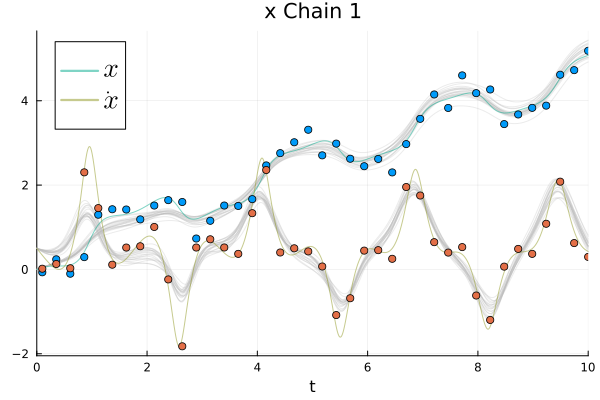

In [44]:
#| output: false
#| echo: false
plot(; title="x Chain 1", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 1:size(finnish_df, 1)
for i in 1:25:500
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=1, label=["\$x\$" "\$\\dot{x}\$"])
scatter!(t, odedata[3:4, :]'; color=[1 2], label="")


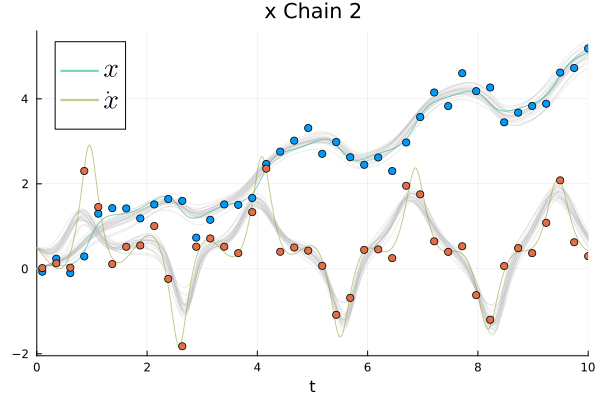

In [45]:
#| output: false
#| echo: false

plot(; title="x Chain 2", legendfontsize=18)
all_sol = finnish_df.predicted_dense
# for i in 1:size(finnish_df, 1)
for i in 501:25:1000
    plot!(all_sol[i], idxs=[3, 4]; alpha=0.3, color="#BBBBBB", label="")
end

# Plot simulations and noise observations
plot!(sol, idxs=[3, 4]; alpha=0.5, linewidth=1, label=["\$x\$" "\$\\dot{x}\$"])
scatter!(t, odedata[3:4, :]'; color=[1 2], label="")


## Summary
